In [2]:
import numpy as np
import pandas as pd
import os
import zipfile
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as ss
from akapriori import apriori
pd.options.display.max_rows = 20
%matplotlib inline
import datetime
from IPython.display import display
import random
import armine
import networkx as nx
import hashlib

sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )



In [2]:

orders_all = pd.read_csv("./orders.csv",index_col=None,header=0)
orders_prod_p=pd.read_csv("./order_products__prior.csv",index_col=None,header=0)
orders_prod_t=pd.read_csv("./order_products__train.csv",index_col=None,header=0)
products=pd.read_csv("./products.csv",index_col=None,header=0)
dept=pd.read_csv("./departments.csv",index_col=None,header=0)
aisles=pd.read_csv("./aisles.csv",index_col=None,header=0)
orders_prod_p=orders_prod_p.append(orders_prod_t)

/tmp/ipykernel_67453/4279196174.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  orders_prod_p=orders_prod_p.append(orders_prod_t)


In [3]:
len(orders_prod_p)

33819106

In [4]:
len(orders_all)

3421083

In [5]:
orders_all.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:

orders_prod_p.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
len(orders_all.user_id.drop_duplicates())

206209

In [8]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
len(products)

49688

In [10]:

dept.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [11]:

aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


# apriori - product 편

In [3]:
orders_prod_norm=orders_prod_p.merge(orders_all,on="order_id")
orders_prod_norm=orders_prod_norm.merge(products,on="product_id")
orders_prod_norm=orders_prod_norm.merge(aisles,on="aisle_id")
orders_prod_norm=orders_prod_norm.merge(dept,on="department_id")
orders_prod_norm.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs


In [13]:
# total_orders = pd.read_parquet('total_orders.parquet',engine='fastparquet')
# orders_prod_norm = total_orders

In [14]:
g=orders_prod_norm.product_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["product_id","count"]
g_products=g.merge(products,on="product_id")
g_products.head()

,product_id,count,product_name,aisle_id,department_id
0,24852,491291,Banana,24,4
1,13176,394930,Bag of Organic Bananas,24,4
2,21137,275577,Organic Strawberries,24,4
3,21903,251705,Organic Baby Spinach,123,4
4,47209,220877,Organic Hass Avocado,24,4


<Figure size 4800x3840 with 0 Axes>

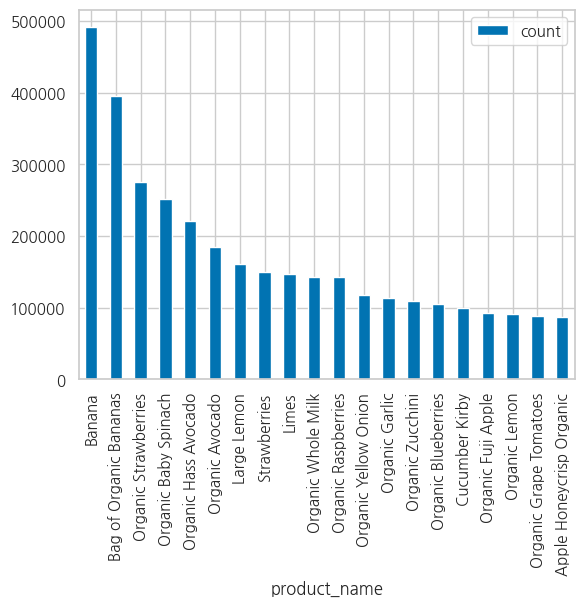

In [15]:
my_dpi=96
plt.figure(figsize=(50, 40), dpi=my_dpi)
plt.gcf().subplots_adjust(bottom=0.15)
g_products.head(20).plot(kind="bar",x="product_name",y="count")
plt.savefig("chart1.png",dpi=1000,bbox_inches="tight" )


(1.0, 679.6703431619201)


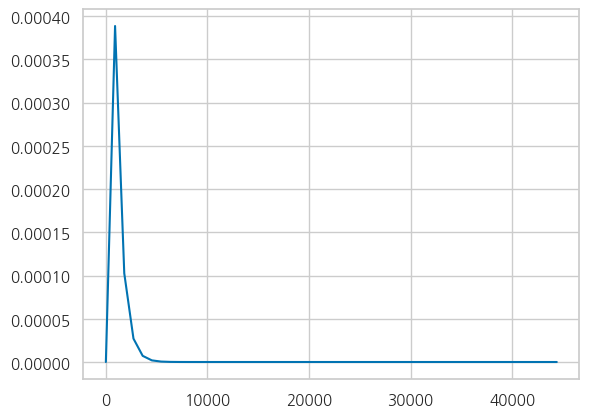

In [16]:
#g_products[g_products["count"]>10].hist("count",bins=50)
P=ss.expon.fit(g_products["count"])
print(P)
rX=np.linspace(0,44380)
rP =ss.expon.pdf(rX,*P)
plt.plot(rX,rP)

In [17]:
g=orders_prod_norm.department_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["department_id","count"]
g_dept=g.merge(dept,on="department_id")
g_dept.head(5)

,department_id,count,department
0,4,9888378,produce
1,16,5631067,dairy eggs
2,19,3006412,snacks
3,7,2804175,beverages
4,1,2336858,frozen


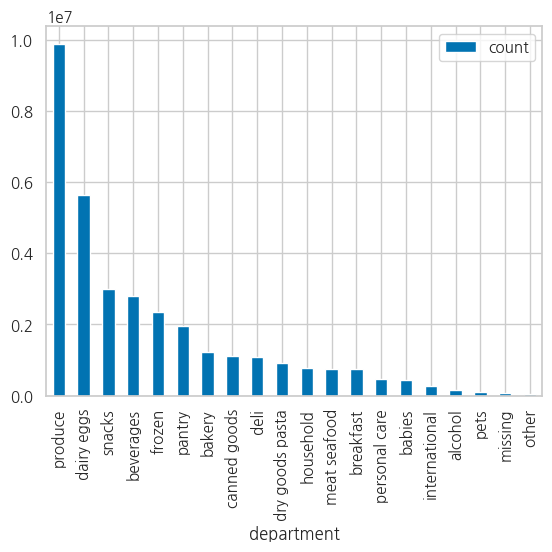

In [18]:
g_dept.head(20).plot(kind="bar",x="department",y="count")
plt.savefig("chart2.png",dpi=1000,bbox_inches="tight" )

(35932.0, 1574501.619047619)


/home/doeun/anaconda3/envs/aiffel_eda/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/doeun/anaconda3/envs/aiffel_eda/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


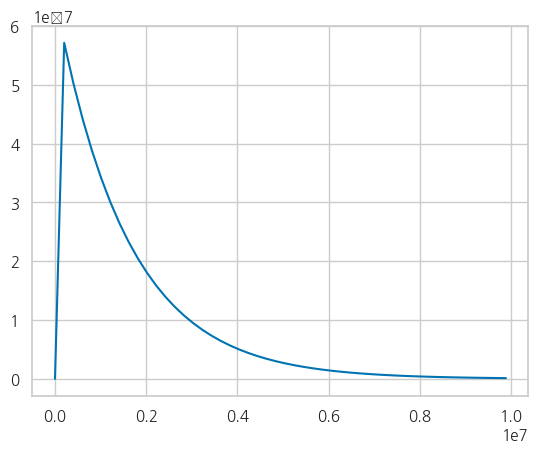

In [19]:
P=ss.expon.fit(g_dept["count"])
print(P)
rX=np.linspace(0,g_dept["count"].max())
rP =ss.expon.pdf(rX,*P)
plt.plot(rX,rP)

In [20]:
g=orders_prod_norm.aisle_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["aisle_id","count"]
g_aisles=g.merge(aisles,on="aisle_id")
g_aisles.head()

,aisle_id,count,aisle
0,24,3792661,fresh fruits
1,83,3568630,fresh vegetables
2,123,1843806,packaged vegetables fruits
3,120,1507583,yogurt
4,21,1021462,packaged cheese


<Axes: xlabel='aisle'>

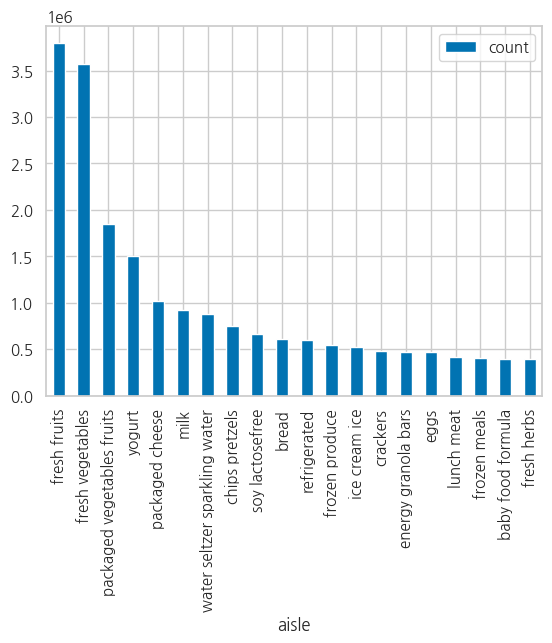

In [21]:
g_aisles.head(20).plot(kind="bar",x="aisle",y="count")

(5147.0, 247234.38805970148)


/home/doeun/anaconda3/envs/aiffel_eda/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/doeun/anaconda3/envs/aiffel_eda/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


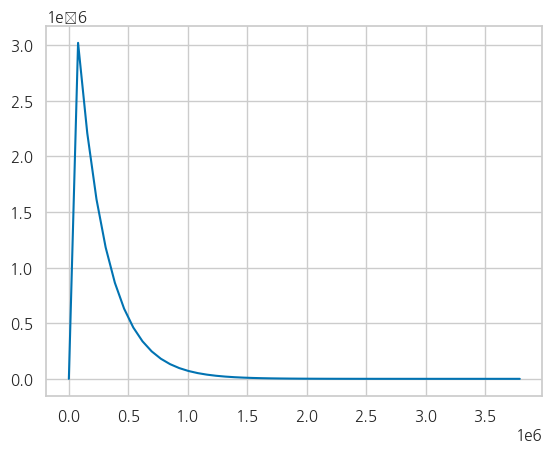

In [22]:
P=ss.expon.fit(g_aisles["count"])
print(P)
rX=np.linspace(0,g_aisles["count"].max())
rP =ss.expon.pdf(rX,*P)
plt.plot(rX,rP)

In [23]:
orders_prod_norm.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs


In [24]:
orders_prod_norm["product_id_str"]=orders_prod_norm["product_id"].astype(str)
g=orders_prod_norm.groupby("order_id")["product_name"]
g1=g.apply(lambda x: ','.join(x.str.replace(","," ")))
g2=pd.DataFrame(g1)
g2.reset_index(inplace=True)
g2["prod_list"]=g2.apply(lambda x: tuple(x["product_name"].split(",")),axis=1)
g2

,order_id,product_name,prod_list
0,1,"Bulgarian Yogurt,Organic Whole String Cheese,O...","(Bulgarian Yogurt, Organic Whole String Cheese..."
1,2,"Organic Egg Whites,Michigan Organic Kale,Carro...","(Organic Egg Whites, Michigan Organic Kale, Ca..."
2,3,Total 2% with Strawberry Lowfat Greek Strained...,(Total 2% with Strawberry Lowfat Greek Straine...
3,4,"Plain Pre-Sliced Bagels,Honey/Lemon Cough Drop...","(Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr..."
4,5,"2% Reduced Fat Milk,Mini Original Babybel Chee...","(2% Reduced Fat Milk, Mini Original Babybel Ch..."
...,...,...,...
3346078,3421079,Moisture Soap,"(Moisture Soap,)"
3346079,3421080,"Organic Pasture Raised Brown Eggs,Organic Whol...","(Organic Pasture Raised Brown Eggs, Organic Wh..."
3346080,3421081,"Pepper Jack Cheese Slices,Dijon Mustard,Classi...","(Pepper Jack Cheese Slices, Dijon Mustard, Cla..."
3346081,3421082,"Original Whipped Cream,Original Spray,Strawber...","(Original Whipped Cream, Original Spray, Straw..."


In [25]:

rules = apriori(list(g2["prod_list"]), support=0.008, confidence=0.1, lift=1.0)

In [26]:
rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC, confidence DESC, support DESC

In [27]:
len(rules_sorted)

36

In [28]:
rules_list=[]
for r in rules_sorted:
    rules_list.append([list(r[0])[0],list(r[1])[0],r[2],r[3],r[4]])

In [29]:

df_rules=pd.DataFrame(rules_list)
df_rules.columns=["From","To","Support","Confidence","Lift"]

In [30]:
G=nx.from_pandas_edgelist(df_rules,"From","To","Lift")

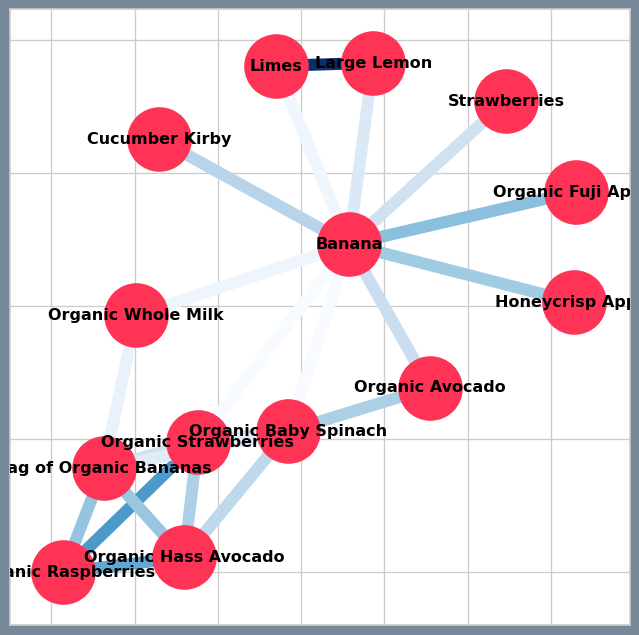

In [31]:
my_dpi=96
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi,facecolor="lightslategray")

plt.facecolor="Black"
edges = G.edges()
colors = [G[u][v]['Lift'] for u,v in edges]
nx.draw_networkx(G,with_labels=True,node_color="#ff3355",node_size=2250,edge_color=colors, arrows=False,font_color="Black",font_weight="bold",font_size=12,style="solid",width=9,edge_cmap=plt.cm.Blues)



plt.savefig("nx.png",format="png" )
plt.show()

# apriori - Department 편

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.plotting import scatterplotmatrix

import numpy as np
import scipy as sc
from pandas import Series,DataFrame
import pandas as pd
# import plot_matrix as plot_matrix

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pandas.plotting import scatter_matrix

from collections import OrderedDict
from fractions import Fraction

get_ipython().magic(u'matplotlib inline')
mpl.rcParams['figure.figsize'] = (10.0, 5)

# import seaborn as sns
# # plt.rcParams
# import seaborn as sns
# color = sns.color_palette()
# import warnings
# warnings.filterwarnings('ignore') 
# #Supress unnecessary warnings for readability and cleaner presentation

/tmp/ipykernel_67453/2673671776.py:23: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')


In [8]:
# Merging Instacart csv files

aisles=pd.read_csv("aisles.csv")
aisles.head()
departments=pd.read_csv("departments.csv")
departments.head()
orders=pd.read_csv("orders.csv")
orders.head()
products=pd.read_csv("products.csv")
products.head()
aisles_merge=pd.merge(products,aisles,on="aisle_id",how="inner")
aisles_merge.head()
dept_merge=pd.merge(departments,aisles_merge,on="department_id",how="inner")
dept_merge.head()


,department_id,department,product_id,product_name,aisle_id,aisle
0,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals
1,1,frozen,30,"Three Cheese Ziti, Marinara with Meatballs",38,frozen meals
2,1,frozen,36,Traditional Lasagna with Meat Sauce Savory Ita...,38,frozen meals
3,1,frozen,81,Blakes Chicken Parmesan Dinner,38,frozen meals
4,1,frozen,100,Peanut Butter & Strawberry Jam Sandwich,38,frozen meals


In [9]:
dept_merge["department_id"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [35]:
prior=pd.read_csv("order_products__prior.csv")
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [36]:
df4=pd.merge(dept_merge,prior, on="department_id",how="inner")
df4.head()

,department_id,department,product_id,product_name,aisle_id,aisle,order_id,add_to_cart_order,reordered
0,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,13379,1,0
1,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,21260,6,1
2,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,43050,2,1
3,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,47541,21,0
4,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,53362,7,0


In [37]:
finaldf=pd.merge(orders,df4,on="order_id",how="inner")
finaldf.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department_id,department,product_id,product_name,aisle_id,aisle,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,7,beverages,196,Soda,77,soft drinks,1,0
1,2539329,1,prior,1,2,8,NaN,16,dairy eggs,14084,Organic Unsweetened Vanilla Almond Milk,91,soy lactosefree,2,0
2,2539329,1,prior,1,2,8,NaN,17,household,26405,XL Pick-A-Size Paper Towel Rolls,54,paper goods,5,0
3,2539329,1,prior,1,2,8,NaN,19,snacks,12427,Original Beef Jerky,23,popcorn jerky,3,0
4,2539329,1,prior,1,2,8,NaN,19,snacks,26088,Aged White Cheddar Popcorn,23,popcorn jerky,4,0


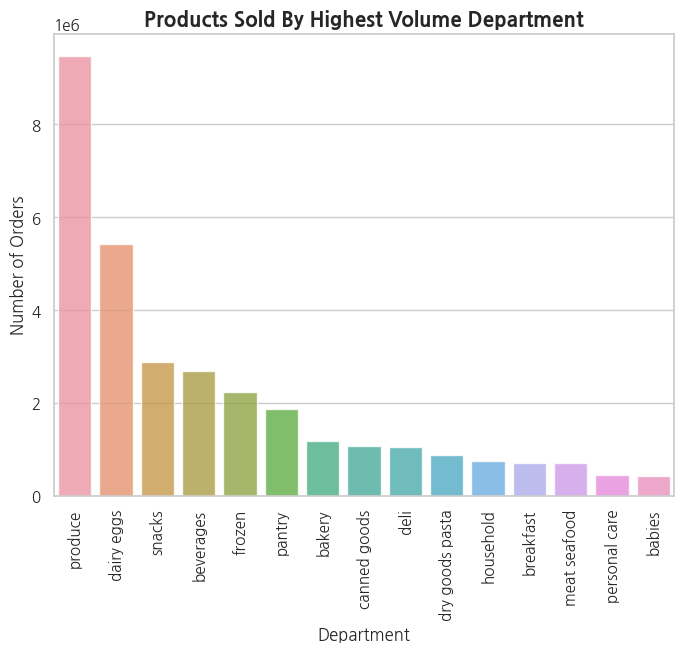

In [38]:
aisle_freq = finaldf['department'].value_counts().head(15)
plt.figure(figsize=(8,6))
sns.barplot(y = aisle_freq.values, x=aisle_freq.index, alpha=0.8)
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title('Products Sold By Highest Volume Department', fontsize=15,fontweight="bold")
plt.xticks(rotation='vertical')
plt.show()

In [39]:
dept_freq = finaldf['department'].value_counts().head(20)
dept_freq

produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
household           738666
breakfast           709569
meat seafood        708931
personal care       447123
babies              423802
international       269253
alcohol             153696
pets                 97724
missing              69145
other                36291
Name: department, dtype: int64

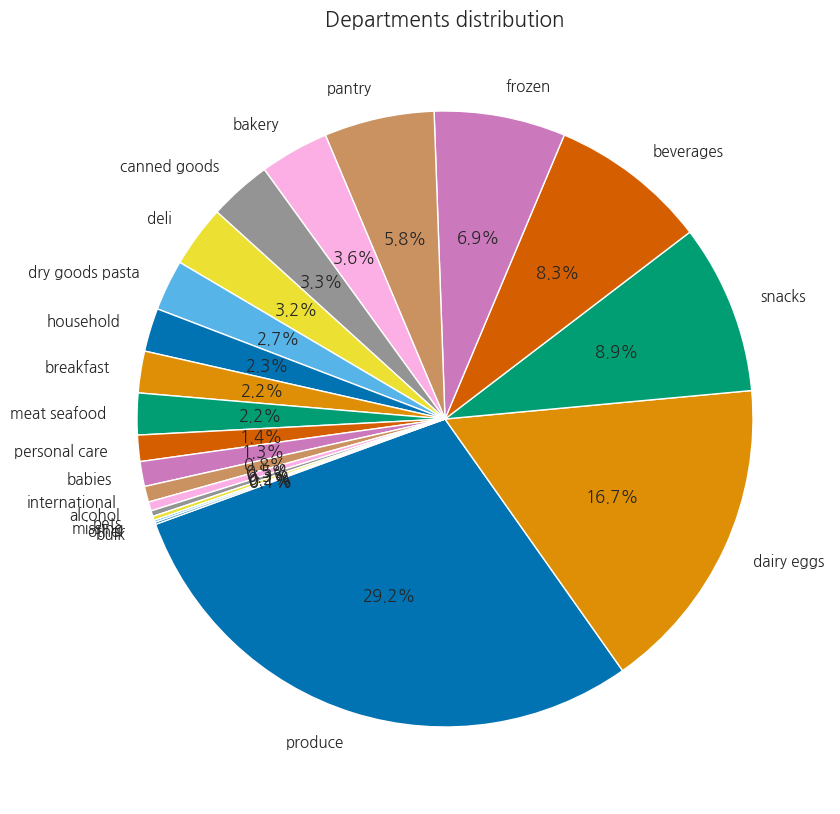

In [40]:
plt.figure(figsize=(10,10))
temp_series = finaldf['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

In [41]:
r1, r2 = 0, 14
def createList(r1, r2):
    return list(range(r1, r2+1))
print(createList(r1, r2))g=orders_prod_norm.product_id.value_counts()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [42]:
basket2=(finaldf.
        groupby(["order_id","department"])["reordered"]
        .count().unstack().reset_index().fillna(0)
        .set_index("order_id"))

basket2

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
order_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,0.0,0.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,...,3.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,7.0,4.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3421080,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3421081,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [43]:
basket2.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
order_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,0.0,0.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,...,3.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,7.0,4.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
def encode_units(x):
    if x <=0:
        return 0
    if x>=1:
        return 1
basket_sets2=basket2.applymap(encode_units)   
basket_sets2

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
order_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,0,0,0,1,0,0,0,1,1,1,...,1,1,1,0,0,1,1,0,1,1
6,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3421080,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3421081,0,0,1,1,0,0,1,1,1,0,...,0,0,0,0,0,1,0,0,0,1


In [45]:
basket_sets2renamed =basket_sets2.rename_axis(None)
basket_sets2renamed.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,0,0,0,1,0,0,0,1,1,1,...,1,1,1,0,0,1,1,0,1,1
6,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [46]:
frequent_itemsets=apriori(basket_sets2,min_support=0.30,use_colnames=True)
rules=association_rules(frequent_itemsets, metric="lift",min_threshold=1)
rules

/home/doeun/anaconda3/envs/aiffel_eda/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(dairy eggs),(beverages),0.677270,0.453315,0.320738,0.473575,1.044692,0.013721,1.038485
1,(beverages),(dairy eggs),0.453315,0.677270,0.320738,0.707539,1.044692,0.013721,1.103496
2,(produce),(dairy eggs),0.749429,0.677270,0.550483,0.734537,1.084556,0.042918,1.215725
3,(dairy eggs),(produce),0.677270,0.749429,0.550483,0.812798,1.084556,0.042918,1.338502
4,(dairy eggs),(snacks),0.677270,0.432815,0.322548,0.476247,1.100347,0.029415,1.082924
5,(snacks),(dairy eggs),0.432815,0.677270,0.322548,0.745232,1.100347,0.029415,1.266761
6,(produce),(snacks),0.749429,0.432815,0.337262,0.450025,1.039762,0.012897,1.031291
7,(snacks),(produce),0.432815,0.749429,0.337262,0.779228,1.039762,0.012897,1.134974


In [47]:
rules_by_lift = rules.sort_values(by="lift", ascending=False)
rules_by_lift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(dairy eggs),(snacks),0.677270,0.432815,0.322548,0.476247,1.100347,0.029415,1.082924
5,(snacks),(dairy eggs),0.432815,0.677270,0.322548,0.745232,1.100347,0.029415,1.266761
2,(produce),(dairy eggs),0.749429,0.677270,0.550483,0.734537,1.084556,0.042918,1.215725
3,(dairy eggs),(produce),0.677270,0.749429,0.550483,0.812798,1.084556,0.042918,1.338502
0,(dairy eggs),(beverages),0.677270,0.453315,0.320738,0.473575,1.044692,0.013721,1.038485
1,(beverages),(dairy eggs),0.453315,0.677270,0.320738,0.707539,1.044692,0.013721,1.103496
6,(produce),(snacks),0.749429,0.432815,0.337262,0.450025,1.039762,0.012897,1.031291
7,(snacks),(produce),0.432815,0.749429,0.337262,0.779228,1.039762,0.012897,1.134974


In [48]:
rules_2=rules_by_lift[(rules_by_lift["lift"]>=1.0)& 
     (rules_by_lift["confidence"]>=0.5)]
rules_2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(snacks),(dairy eggs),0.432815,0.677270,0.322548,0.745232,1.100347,0.029415,1.266761
2,(produce),(dairy eggs),0.749429,0.677270,0.550483,0.734537,1.084556,0.042918,1.215725
3,(dairy eggs),(produce),0.677270,0.749429,0.550483,0.812798,1.084556,0.042918,1.338502
1,(beverages),(dairy eggs),0.453315,0.677270,0.320738,0.707539,1.044692,0.013721,1.103496
7,(snacks),(produce),0.432815,0.749429,0.337262,0.779228,1.039762,0.012897,1.134974


In [49]:
rules_2.to_csv("final_dept.csv")

In [50]:
basket2["dairy eggs"].sum()

5414016.0

In [51]:
basket2["beverages"].sum()

2690129.0

In [52]:
cols = ['antecedents','consequents']
rules_2[cols] = rules_2[cols].applymap(lambda x: tuple(x))
rules_2.head()

/tmp/ipykernel_47218/3460720408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_2[cols] = rules_2[cols].applymap(lambda x: tuple(x))


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,"(snacks,)","(dairy eggs,)",0.432815,0.677270,0.322548,0.745232,1.100347,0.029415,1.266761
2,"(produce,)","(dairy eggs,)",0.749429,0.677270,0.550483,0.734537,1.084556,0.042918,1.215725
3,"(dairy eggs,)","(produce,)",0.677270,0.749429,0.550483,0.812798,1.084556,0.042918,1.338502
1,"(beverages,)","(dairy eggs,)",0.453315,0.677270,0.320738,0.707539,1.044692,0.013721,1.103496
7,"(snacks,)","(produce,)",0.432815,0.749429,0.337262,0.779228,1.039762,0.012897,1.134974


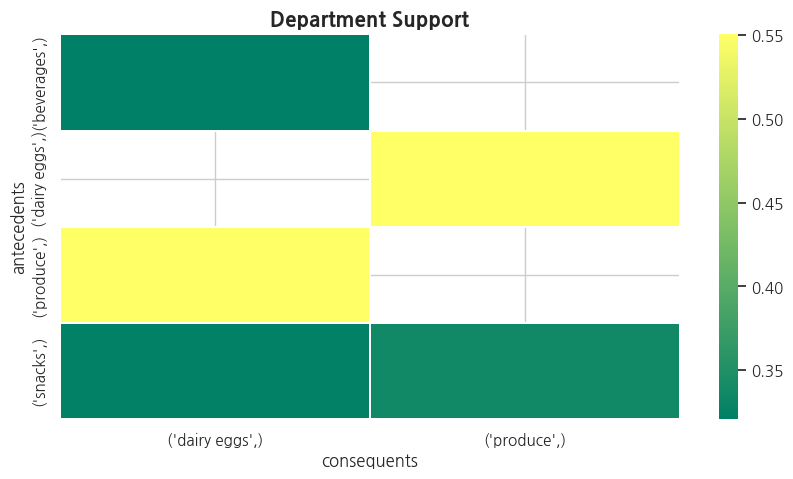

In [53]:
data = rules_2.pivot_table(index='antecedents', columns='consequents', values='support')
# sns.palplot(sns.color_palette("BuGn_r"))
plt.title("Department Support",fontsize=15,fontweight="bold")


ax = sns.heatmap(data, linewidths=0.1,cmap="summer")
plt.savefig("dept_support.png", bbox_inches="tight")

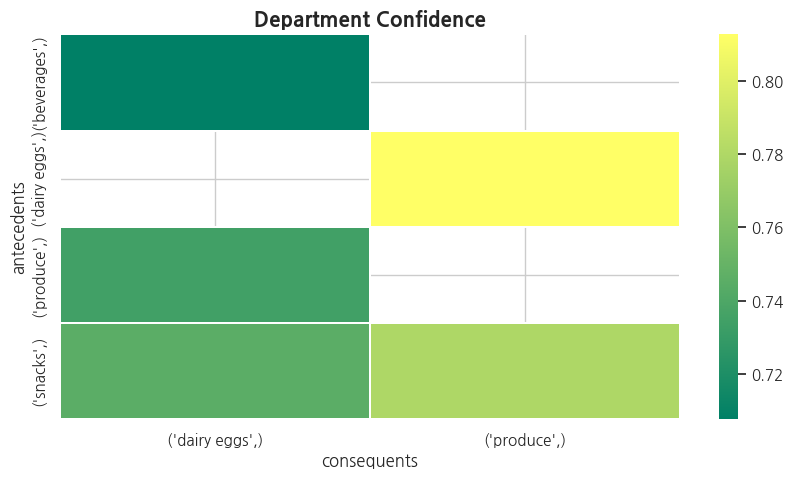

<Figure size 1000x500 with 0 Axes>

In [54]:
data = rules_2.pivot_table(index='antecedents', columns='consequents', values='confidence')
plt.title("Department Confidence",fontsize=15,fontweight="bold")

ax = sns.heatmap(data,linewidths=0.1,cmap="summer")
plt.show()
plt.savefig("dept_confidence.png", bbox_inches="tight")

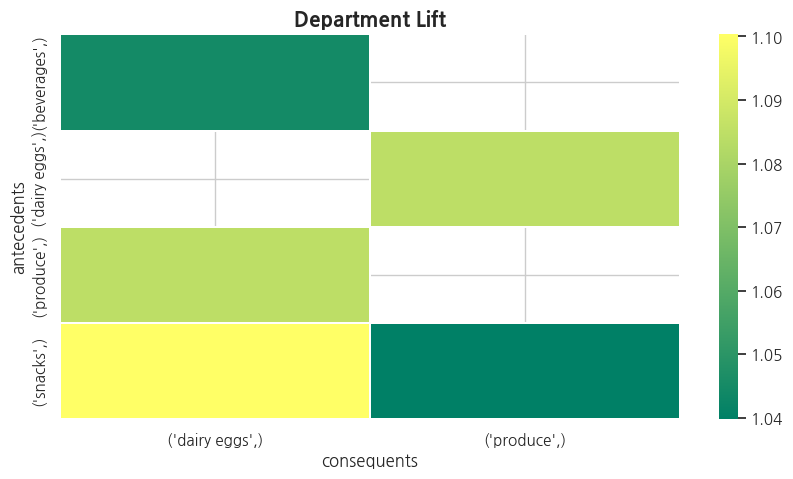

In [55]:
data = rules_2.pivot_table(index='antecedents', columns='consequents', values='lift')
plt.title("Department Lift",fontsize=15,fontweight="bold")

ax = sns.heatmap(data, linewidths=0.2,cmap="summer")
plt.savefig("dept_lift.png", bbox_inches="tight")
plt.show()

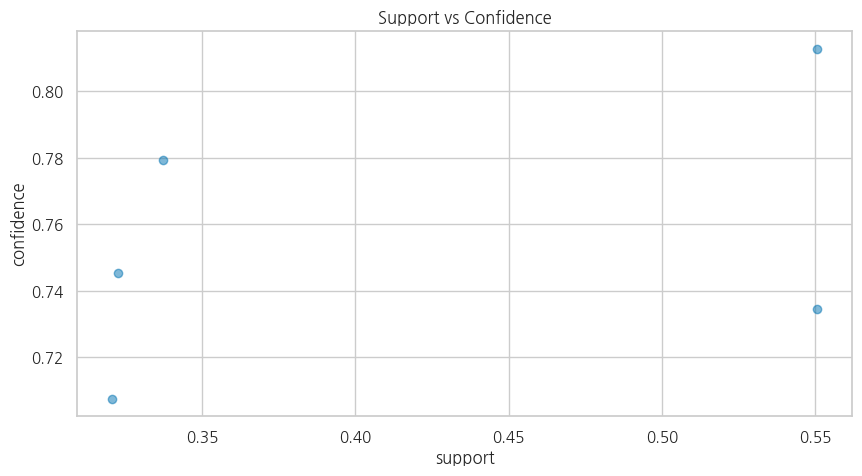

In [56]:
# Support V/s Confidence
plt.scatter(rules_2['support'], rules_2['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

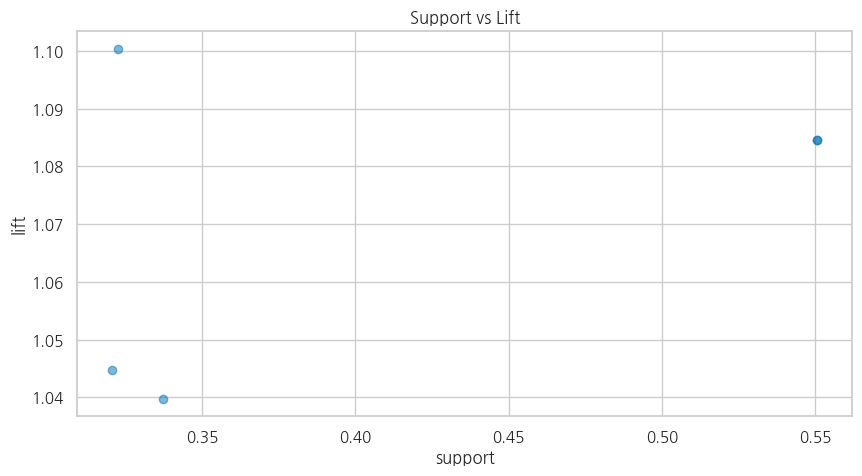

In [57]:
plt.scatter(rules_2['support'], rules_2['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

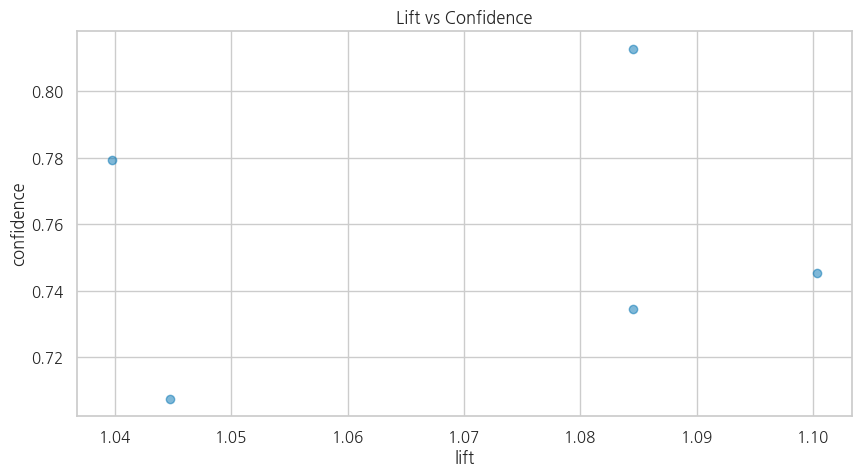

In [58]:
plt.scatter(rules_2['lift'], rules_2['confidence'], alpha=0.5)
plt.xlabel('lift')
plt.ylabel('confidence')
plt.title('Lift vs Confidence')
plt.show()


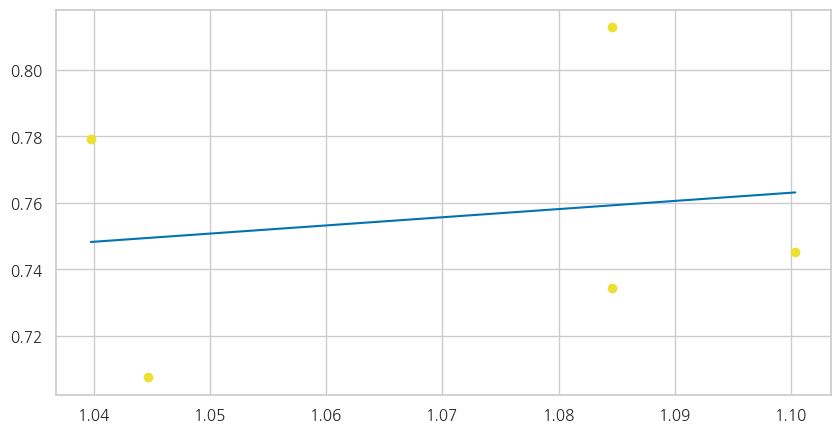

In [59]:
fit=np.polyfit(rules_2['lift'],rules_2['confidence'],1)
fit_fn=np.poly1d(fit)
plt.plot(rules_2['lift'],rules_2['confidence'],'yo',rules_2['lift'],
        fit_fn(rules_2['lift']))
plt.show()

In [3]:
orders_all = pd.read_csv("./orders.csv",index_col=None,header=0)
orders_prod_p=pd.read_csv("./order_products__prior.csv",index_col=None,header=0)
orders_prod_t=pd.read_csv("./order_products__train.csv",index_col=None,header=0)
products=pd.read_csv("./products.csv",index_col=None,header=0)
dept=pd.read_csv("./departments.csv",index_col=None,header=0)
aisles=pd.read_csv("./aisles.csv",index_col=None,header=0)
orders_prod_p=orders_prod_p.append(orders_prod_t)

orders_prod_norm=orders_prod_p.merge(orders_all,on="order_id")
orders_prod_norm=orders_prod_norm.merge(products,on="product_id")
orders_prod_norm=orders_prod_norm.merge(aisles,on="aisle_id")
orders_prod_norm=orders_prod_norm.merge(dept,on="department_id")
orders_prod_norm.head()

# products = products.merge(dept, on ='department_id')
g=orders_prod_norm.department_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["department_id","count"]
g_products = g.merge(dept, on='department_id')
# g_products=g.merge(products,on="department_id")
g_products
# g_products = g_products.groupby(['department_id', 'count','department'])


/tmp/ipykernel_68353/724478028.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  orders_prod_p=orders_prod_p.append(orders_prod_t)


,department_id,count,department
0,4,9888378,produce
1,16,5631067,dairy eggs
2,19,3006412,snacks
3,7,2804175,beverages
4,1,2336858,frozen
...,...,...,...
16,5,159294,alcohol
17,8,102221,pets
18,21,77396,missing
19,2,38086,other


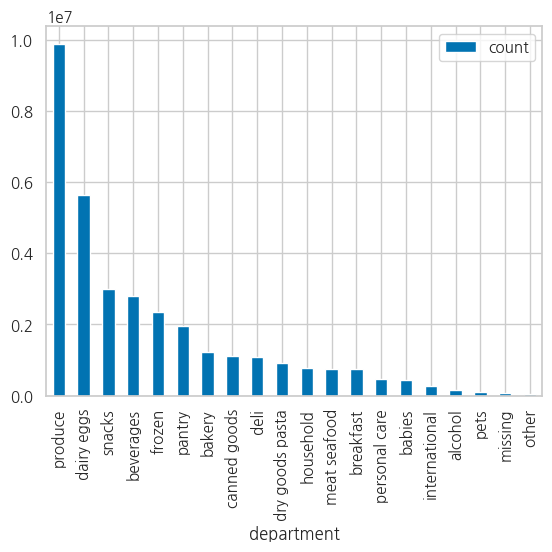

In [9]:

g_products.head(20).plot(kind="bar",x="department",y="count")
plt.savefig("chart2.png",dpi=1000,bbox_inches="tight" )



(35932.0, 1574501.619047619)


/home/doeun/anaconda3/envs/aiffel_eda/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/doeun/anaconda3/envs/aiffel_eda/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


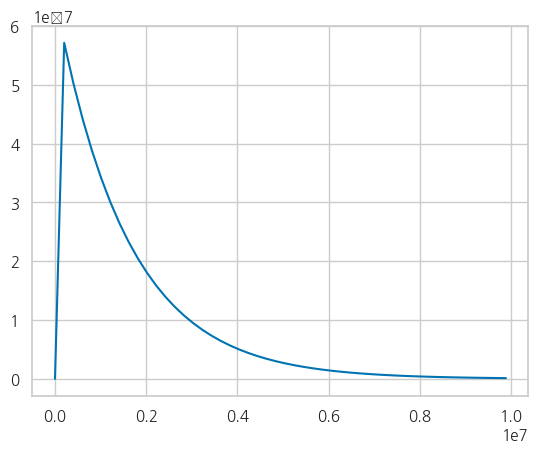

In [10]:

P=ss.expon.fit(g_products["count"])
print(P)
rX=np.linspace(0,g_products["count"].max())
rP =ss.expon.pdf(rX,*P)
plt.plot(rX,rP)

In [11]:

orders_prod_norm["department_id_str"]=orders_prod_norm["department_id"].astype(str)
g=orders_prod_norm.groupby("order_id")["department"]
g1=g.apply(lambda x: ','.join(x.str.replace(","," ")))
g2=pd.DataFrame(g1)
g2.reset_index(inplace=True)
g2["department_list"]=g2.apply(lambda x: tuple(x["department"].split(",")),axis=1)
g2



,order_id,department,department_list
0,1,"dairy eggs,dairy eggs,dairy eggs,produce,produ...","(dairy eggs, dairy eggs, dairy eggs, produce, ..."
1,2,"dairy eggs,produce,produce,produce,pantry,pant...","(dairy eggs, produce, produce, produce, pantry..."
2,3,"dairy eggs,dairy eggs,dairy eggs,produce,produ...","(dairy eggs, dairy eggs, dairy eggs, produce, ..."
3,4,"bakery,personal care,snacks,snacks,snacks,snac...","(bakery, personal care, snacks, snacks, snacks..."
4,5,"dairy eggs,dairy eggs,dairy eggs,produce,produ...","(dairy eggs, dairy eggs, dairy eggs, produce, ..."
...,...,...,...
3346078,3421079,personal care,"(personal care,)"
3346079,3421080,"dairy eggs,dairy eggs,dairy eggs,dairy eggs,da...","(dairy eggs, dairy eggs, dairy eggs, dairy egg..."
3346080,3421081,"dairy eggs,pantry,bakery,snacks,beverages,deli...","(dairy eggs, pantry, bakery, snacks, beverages..."
3346081,3421082,"dairy eggs,dairy eggs,produce,produce,meat sea...","(dairy eggs, dairy eggs, produce, produce, mea..."


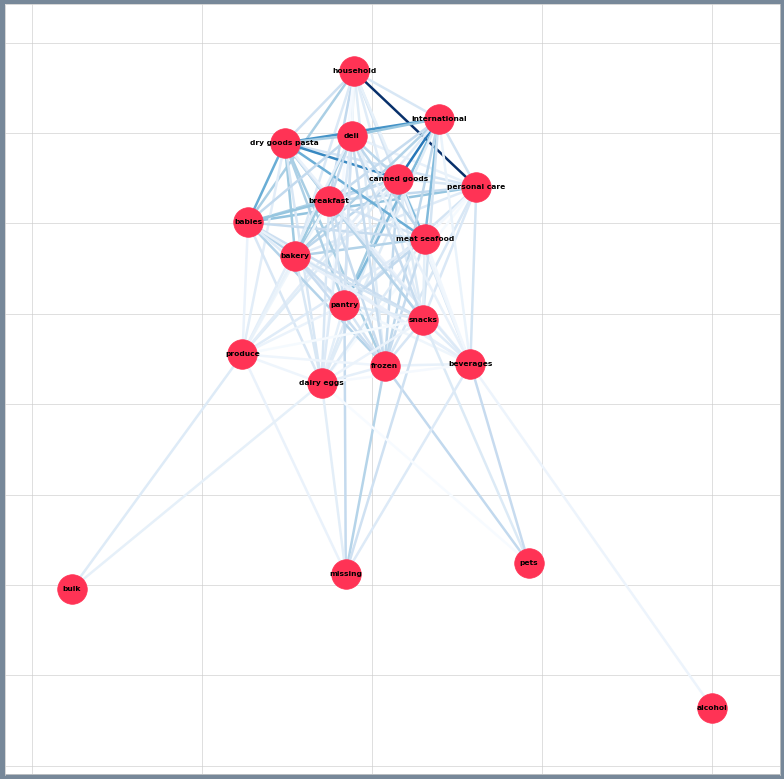

In [15]:

rules = apriori(list(g2["department_list"]), support=0.008, confidence=0.1, lift=1.0)

rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC, confidence DESC, support DESC

len(rules_sorted)

rules_list=[]
for r in rules_sorted:
    rules_list.append([list(r[0])[0],list(r[1])[0],r[2],r[3],r[4]])


df_rules=pd.DataFrame(rules_list)
df_rules.columns=["From","To","Support","Confidence","Lift"]

G=nx.from_pandas_edgelist(df_rules,"From","To","Lift")

my_dpi=45
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi,facecolor="lightslategray")

plt.facecolor="Black"
edges = G.edges()
colors = [G[u][v]['Lift'] for u,v in edges]
nx.draw_networkx(G,with_labels=True,node_color="#ff3355",node_size=2250,edge_color=colors, arrows=False,font_color="Black",font_weight="bold",font_size=12,style="solid",width=4,edge_cmap=plt.cm.Blues)



plt.savefig("nx.png",format="png" )
plt.show()

# apriori - aisles 편

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import numpy as np
import scipy as sc
from pandas import Series,DataFrame
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import savefig


from collections import OrderedDict
from fractions import Fraction

get_ipython().magic(u'matplotlib inline')
mpl.rcParams['figure.figsize'] = (10.0, 5)

# import seaborn as sns
# # plt.rcParams
# import seaborn as sns
# color = sns.color_palette()
# import warnings
# warnings.filterwarnings('ignore') 
# #Supress unnecessary warnings for readability and cleaner presentation

/tmp/ipykernel_47353/2356261827.py:21: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')


In [3]:
aisles=pd.read_csv("aisles.csv")
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
departments=pd.read_csv("departments.csv")
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
orders=pd.read_csv("orders.csv")
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:

products=pd.read_csv("products.csv")
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
aisles_merge=pd.merge(products,aisles,on="aisle_id",how="inner")
aisles_merge.head()

,product_id,product_name,aisle_id,department_id,aisle
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes
2,102,Danish Butter Cookies,61,19,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes


In [8]:
dept_merge=pd.merge(departments,aisles_merge,on="department_id",how="inner")
dept_merge.head()

,department_id,department,product_id,product_name,aisle_id,aisle
0,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals
1,1,frozen,30,"Three Cheese Ziti, Marinara with Meatballs",38,frozen meals
2,1,frozen,36,Traditional Lasagna with Meat Sauce Savory Ita...,38,frozen meals
3,1,frozen,81,Blakes Chicken Parmesan Dinner,38,frozen meals
4,1,frozen,100,Peanut Butter & Strawberry Jam Sandwich,38,frozen meals


In [9]:
prior=pd.read_csv("order_products__prior.csv")
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
df4=pd.merge(dept_merge,prior, on="product_id",how="inner")
df4.head()

,department_id,department,product_id,product_name,aisle_id,aisle,order_id,add_to_cart_order,reordered
0,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,13379,1,0
1,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,21260,6,1
2,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,43050,2,1
3,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,47541,21,0
4,1,frozen,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,53362,7,0


In [11]:
finaldf=pd.merge(orders,df4,on="order_id",how="inner")
finaldf.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department_id,department,product_id,product_name,aisle_id,aisle,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,7,beverages,196,Soda,77,soft drinks,1,0
1,2539329,1,prior,1,2,8,NaN,16,dairy eggs,14084,Organic Unsweetened Vanilla Almond Milk,91,soy lactosefree,2,0
2,2539329,1,prior,1,2,8,NaN,17,household,26405,XL Pick-A-Size Paper Towel Rolls,54,paper goods,5,0
3,2539329,1,prior,1,2,8,NaN,19,snacks,12427,Original Beef Jerky,23,popcorn jerky,3,0
4,2539329,1,prior,1,2,8,NaN,19,snacks,26088,Aged White Cheddar Popcorn,23,popcorn jerky,4,0


In [12]:
unique_aisle_names = finaldf["aisle"].unique()
unique_aisle_names
len(unique_aisle_names)

134

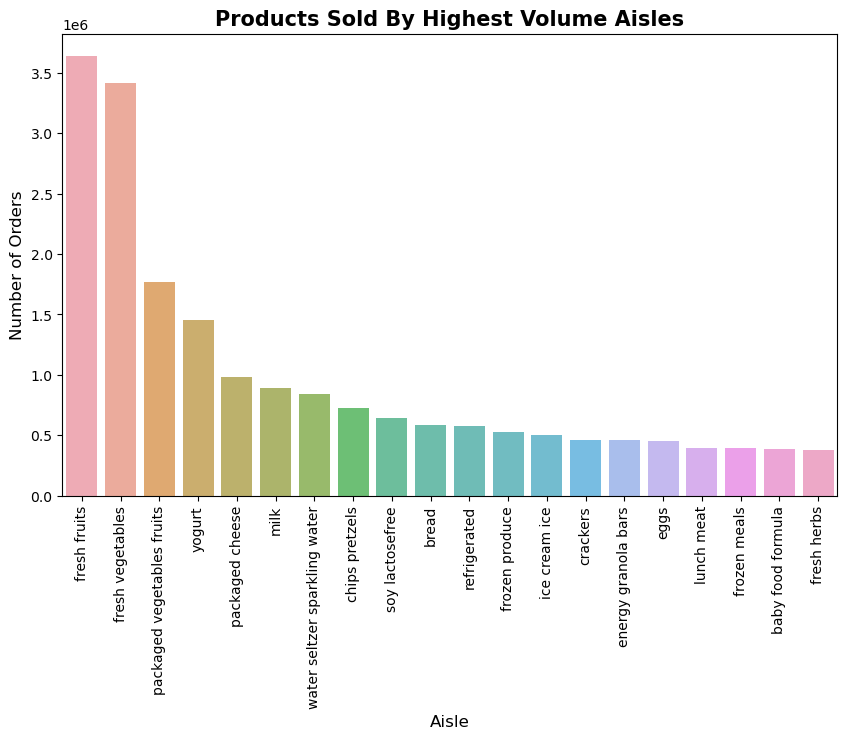

fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
refrigerated                      575881
frozen produce                    522654
ice cream ice                     498425
crackers                          458838
energy granola bars               456386
eggs                              452134
lunch meat                        395130
frozen meals                      390299
baby food formula                 382456
fresh herbs                       377741
Name: aisle, dtype: int64

<Figure size 1000x500 with 0 Axes>

In [14]:
aisle_freq = finaldf['aisle'].value_counts().head(20)
plt.figure(figsize=(10,6))
sns.barplot(x= aisle_freq.index, y=aisle_freq.values, alpha=0.8)
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.title('Products Sold By Highest Volume Aisles', fontsize=15,fontweight="bold")
plt.xticks(rotation='vertical')
plt.show()
plt.savefig("aisles.png",bbox_inches="tight")
aisle_freq

In [15]:
r1, r2 = 0, 19
def createList(r1, r2):
    return list(range(r1, r2+1))
print(createList(r1, r2))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [17]:
basket1=(finaldf.
        groupby(["order_id","aisle"])["reordered"]
        .count().unstack().reset_index().fillna(0)
        .set_index("order_id"))

basket1

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3421080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3421081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [18]:
basket1.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
def encode_units(x):
    if x <=0:
        return 0
    if x>=1:
        return 1
basket_sets1=basket1.applymap(encode_units)   
basket_sets1

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3421080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3421081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
frequent_itemsets=apriori(basket_sets1,min_support=0.20,use_colnames=True)
rules=association_rules(frequent_itemsets, metric="lift",min_threshold=1)
rules

/home/doeun/anaconda3/envs/aiffel_eda/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fresh fruits),(fresh vegetables),0.557027,0.444071,0.317762,0.570460,1.284617,0.070403,1.294245
1,(fresh vegetables),(fresh fruits),0.444071,0.557027,0.317762,0.715566,1.284617,0.070403,1.557384
2,(packaged vegetables fruits),(fresh fruits),0.366808,0.557027,0.270270,0.736814,1.322763,0.065948,1.683120
3,(fresh fruits),(packaged vegetables fruits),0.557027,0.366808,0.270270,0.485201,1.322763,0.065948,1.229977
4,(packaged vegetables fruits),(fresh vegetables),0.366808,0.444071,0.234454,0.639173,1.439349,0.071565,1.540708
5,(fresh vegetables),(packaged vegetables fruits),0.444071,0.366808,0.234454,0.527966,1.439349,0.071565,1.341410


In [21]:
rules_by_lift = rules.sort_values(by="lift", ascending=False)
rules_by_lift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(packaged vegetables fruits),(fresh vegetables),0.366808,0.444071,0.234454,0.639173,1.439349,0.071565,1.540708
5,(fresh vegetables),(packaged vegetables fruits),0.444071,0.366808,0.234454,0.527966,1.439349,0.071565,1.341410
3,(fresh fruits),(packaged vegetables fruits),0.557027,0.366808,0.270270,0.485201,1.322763,0.065948,1.229977
2,(packaged vegetables fruits),(fresh fruits),0.366808,0.557027,0.270270,0.736814,1.322763,0.065948,1.683120
0,(fresh fruits),(fresh vegetables),0.557027,0.444071,0.317762,0.570460,1.284617,0.070403,1.294245
1,(fresh vegetables),(fresh fruits),0.444071,0.557027,0.317762,0.715566,1.284617,0.070403,1.557384


In [22]:
basket_sets1["fresh fruits"].sum()

1790771

In [23]:
basket_sets1["fresh vegetables"].sum()

1427631

In [24]:

rules_2=rules[(rules["lift"]>=1.32) & 
     (rules["confidence"]>=0.55)] 
rules_2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(packaged vegetables fruits),(fresh fruits),0.366808,0.557027,0.270270,0.736814,1.322763,0.065948,1.683120
4,(packaged vegetables fruits),(fresh vegetables),0.366808,0.444071,0.234454,0.639173,1.439349,0.071565,1.540708


In [25]:
rules_2.to_csv("final_aisles.csv")

In [26]:
cols = ['antecedents','consequents']
rules_2[cols] = rules_2[cols].applymap(lambda x: tuple(x))
rules_2.head()

/tmp/ipykernel_47353/3460720408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_2[cols] = rules_2[cols].applymap(lambda x: tuple(x))


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"(packaged vegetables fruits,)","(fresh fruits,)",0.366808,0.557027,0.270270,0.736814,1.322763,0.065948,1.683120
4,"(packaged vegetables fruits,)","(fresh vegetables,)",0.366808,0.444071,0.234454,0.639173,1.439349,0.071565,1.540708


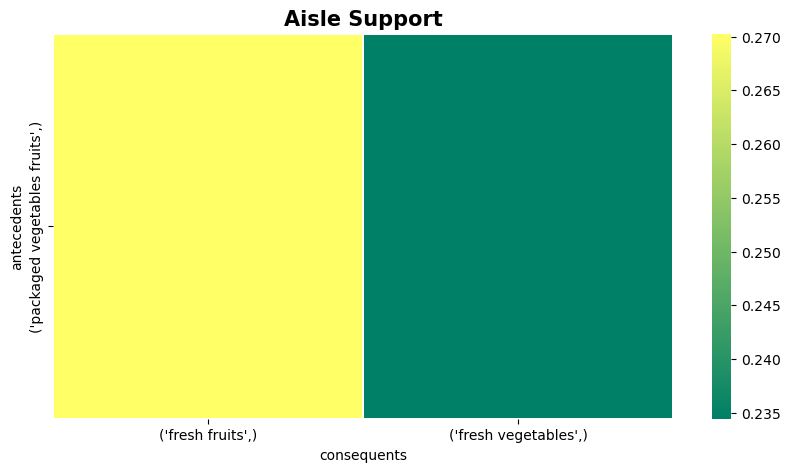

In [27]:
data = rules_2.pivot_table(index='antecedents', columns='consequents', values='support')
plt.title("Aisle Support",fontsize=15,fontweight="bold")


ax = sns.heatmap(data, linewidths=0.1,cmap="summer")
plt.savefig("aisle_support.png", bbox_inches="tight")

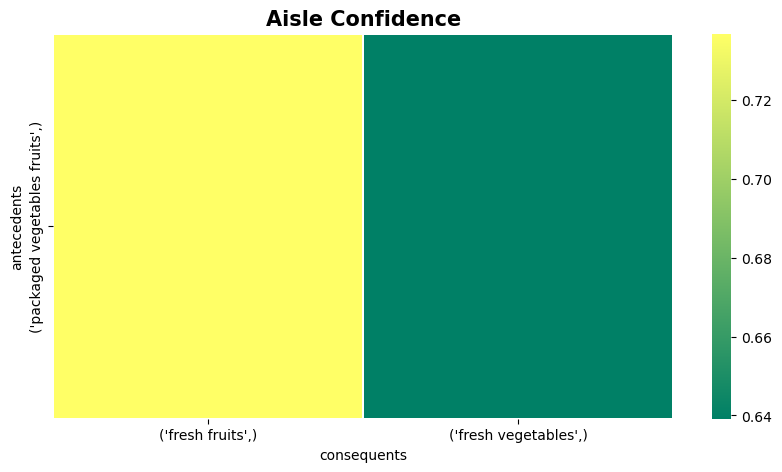

In [28]:
data = rules_2.pivot_table(index='antecedents', columns='consequents', values='confidence')
plt.title("Aisle Confidence",fontsize=15,fontweight="bold")


ax = sns.heatmap(data, linewidths=0.1,cmap="summer")
plt.savefig("aisle_confidence.png", bbox_inches="tight")


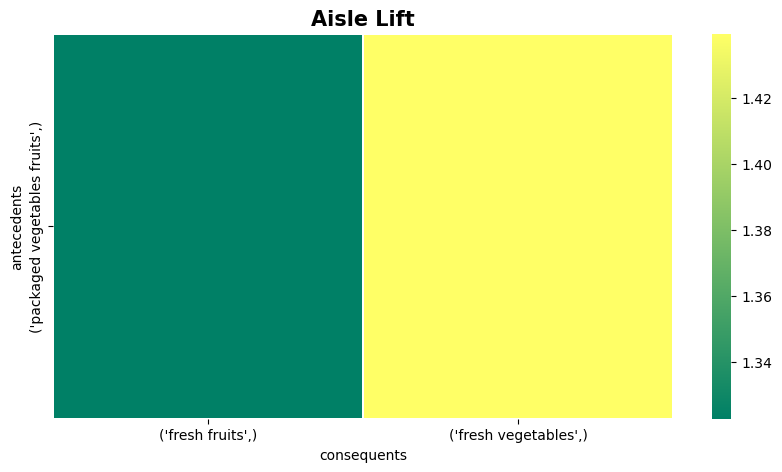

In [29]:
data = rules_2.pivot_table(index='antecedents', columns='consequents', values='lift')
plt.title("Aisle Lift",fontsize=15,fontweight="bold")


ax = sns.heatmap(data, linewidths=0.1,cmap="summer")
plt.savefig("aisle_lift.png", bbox_inches="tight")

In [30]:
import numpy as np
import scipy as sc
from pandas import Series,DataFrame
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from collections import OrderedDict
from fractions import Fraction

get_ipython().magic(u'matplotlib inline')
mpl.rcParams['figure.figsize'] = (10.0, 5)

/tmp/ipykernel_47353/1906379765.py:13: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')


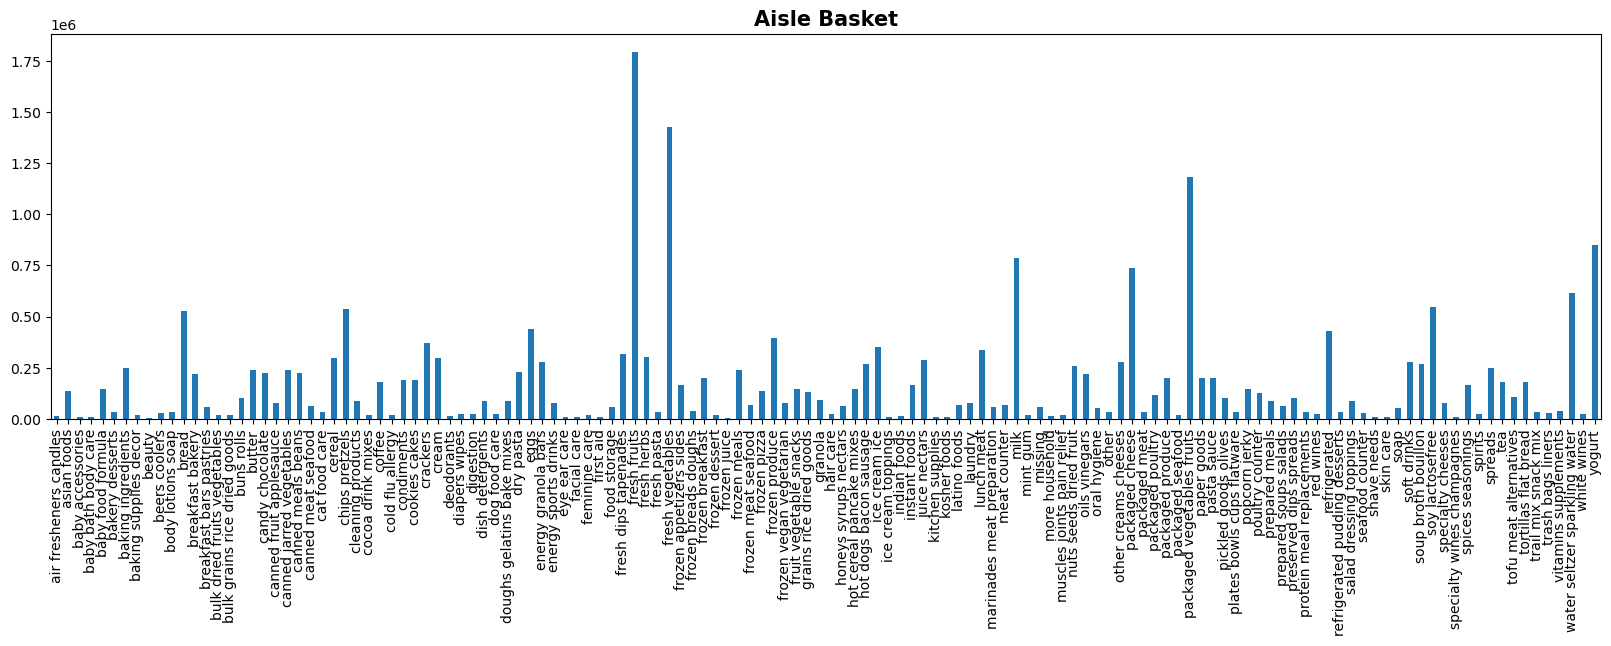

In [31]:
product_support_dict = {}
for column in basket_sets1.columns:
    product_support_dict[column] = sum(basket_sets1[column]>0)
 
# visualise support
fig=pd.Series(product_support_dict).plot(kind="bar",figsize=(20,5))
plt.title("Aisle Basket",fontsize=15,fontweight="bold")
plt.savefig("aisle_basket.png", bbox_inches="tight")


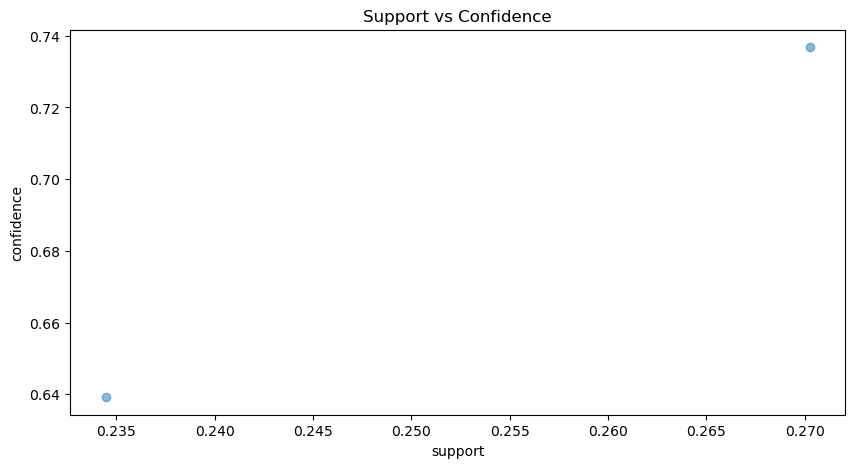

In [32]:
plt.scatter(rules_2['support'], rules_2['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

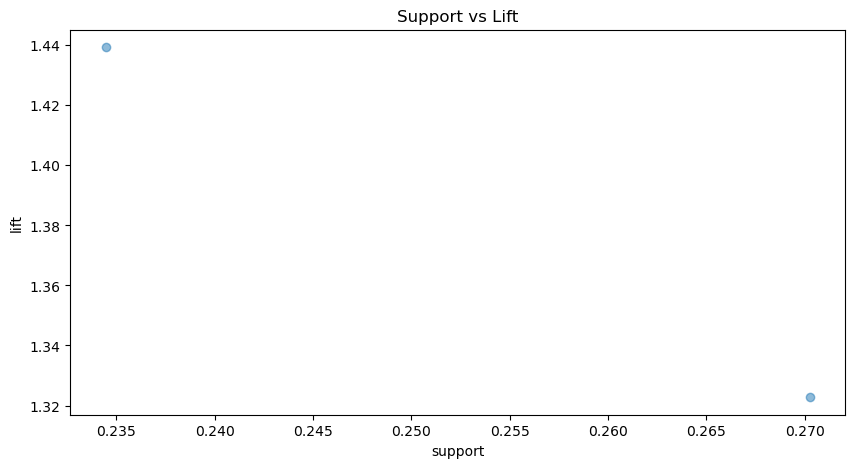

In [33]:
plt.scatter(rules_2['support'], rules_2['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

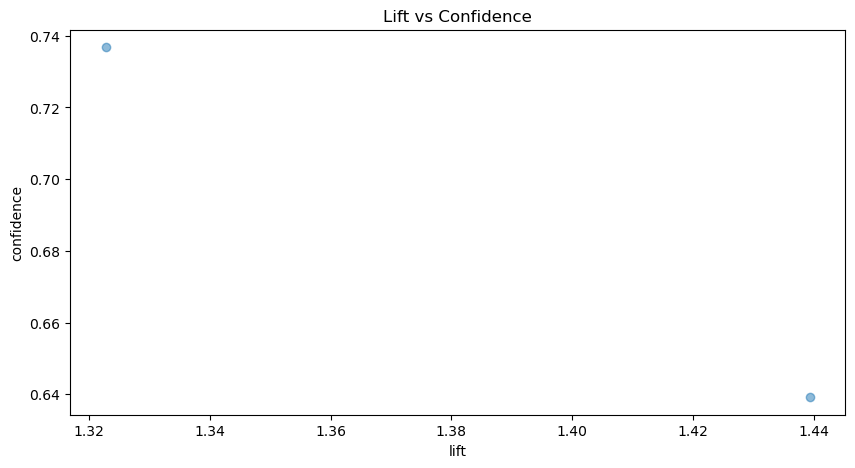

In [34]:
plt.scatter(rules_2['lift'], rules_2['confidence'], alpha=0.5)
plt.xlabel('lift')
plt.ylabel('confidence')
plt.title('Lift vs Confidence')
plt.show()

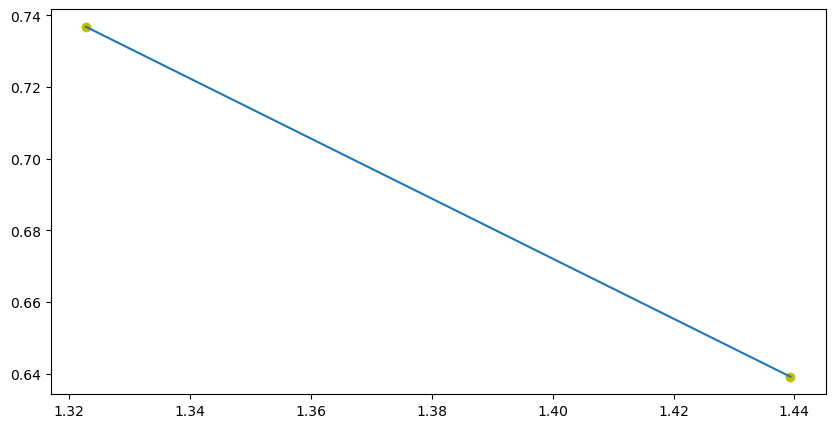

In [35]:
fit=np.polyfit(rules_2['lift'],rules_2['confidence'],1)
fit_fn=np.poly1d(fit)
plt.plot(rules_2['lift'],rules_2['confidence'],'yo',rules_2['lift'],
        fit_fn(rules_2['lift']))
plt.show()

In [16]:
orders_all = pd.read_csv("./orders.csv",index_col=None,header=0)
orders_prod_p=pd.read_csv("./order_products__prior.csv",index_col=None,header=0)
orders_prod_t=pd.read_csv("./order_products__train.csv",index_col=None,header=0)
products=pd.read_csv("./products.csv",index_col=None,header=0)
dept=pd.read_csv("./departments.csv",index_col=None,header=0)
aisles=pd.read_csv("./aisles.csv",index_col=None,header=0)
orders_prod_p=orders_prod_p.append(orders_prod_t)

orders_prod_norm=orders_prod_p.merge(orders_all,on="order_id")
orders_prod_norm=orders_prod_norm.merge(products,on="product_id")
orders_prod_norm=orders_prod_norm.merge(aisles,on="aisle_id")
orders_prod_norm=orders_prod_norm.merge(dept,on="department_id")
orders_prod_norm.head()

# products = products.merge(dept, on ='department_id')
g=orders_prod_norm.aisle_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["aisle_id","count"]
g_products = g.merge(aisles, on='aisle_id')
# g_products=g.merge(products,on="department_id")
g_products
# g_products = g_products.groupby(['department_id', 'count','department'])


/tmp/ipykernel_68353/1649598762.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  orders_prod_p=orders_prod_p.append(orders_prod_t)


,aisle_id,count,aisle
0,24,3792661,fresh fruits
1,83,3568630,fresh vegetables
2,123,1843806,packaged vegetables fruits
3,120,1507583,yogurt
4,21,1021462,packaged cheese
...,...,...,...
129,44,9522,eye ear care
130,102,8909,baby bath body care
131,82,8466,baby accessories
132,132,6455,beauty


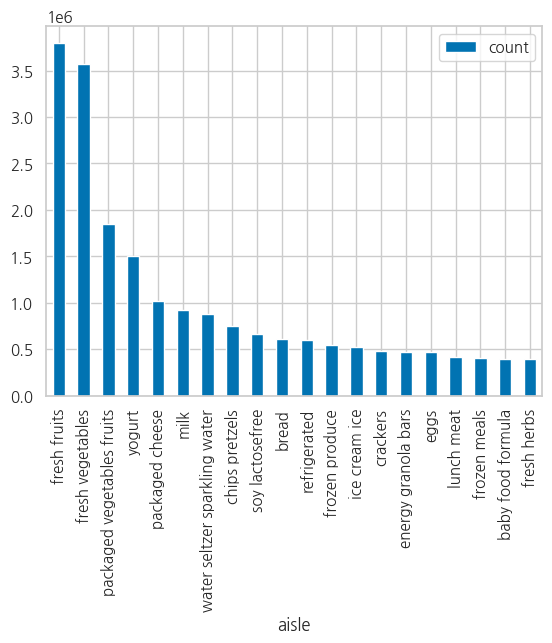

In [17]:

g_products.head(20).plot(kind="bar",x="aisle",y="count")
plt.savefig("chart2.png",dpi=1000,bbox_inches="tight" )



(5147.0, 247234.38805970148)


/home/doeun/anaconda3/envs/aiffel_eda/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/doeun/anaconda3/envs/aiffel_eda/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


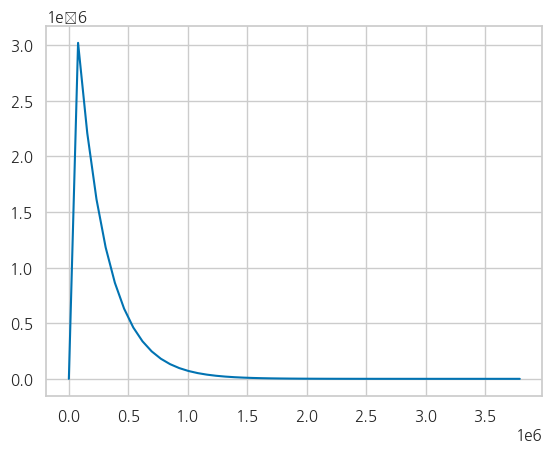

In [18]:

P=ss.expon.fit(g_products["count"])
print(P)
rX=np.linspace(0,g_products["count"].max())
rP =ss.expon.pdf(rX,*P)
plt.plot(rX,rP)

In [19]:

orders_prod_norm["aisle_id_str"]=orders_prod_norm["aisle_id"].astype(str)
g=orders_prod_norm.groupby("order_id")["aisle"]
g1=g.apply(lambda x: ','.join(x.str.replace(","," ")))
g2=pd.DataFrame(g1)
g2.reset_index(inplace=True)
g2["aisle_list"]=g2.apply(lambda x: tuple(x["aisle"].split(",")),axis=1)
g2



,order_id,aisle,aisle_list
0,1,"yogurt,packaged cheese,other creams cheeses,fr...","(yogurt, packaged cheese, other creams cheeses..."
1,2,"eggs,fresh vegetables,fresh vegetables,package...","(eggs, fresh vegetables, fresh vegetables, pac..."
2,3,"yogurt,soy lactosefree,soy lactosefree,fresh v...","(yogurt, soy lactosefree, soy lactosefree, fre..."
3,4,"breakfast bakery,cold flu allergy,energy grano...","(breakfast bakery, cold flu allergy, energy gr..."
4,5,"milk,packaged cheese,packaged cheese,fresh veg...","(milk, packaged cheese, packaged cheese, fresh..."
...,...,...,...
3346078,3421079,soap,"(soap,)"
3346079,3421080,"eggs,milk,butter,butter,butter,fresh vegetable...","(eggs, milk, butter, butter, butter, fresh veg..."
3346080,3421081,"packaged cheese,condiments,bread,chips pretzel...","(packaged cheese, condiments, bread, chips pre..."
3346081,3421082,"cream,butter,fresh fruits,packaged produce,pac...","(cream, butter, fresh fruits, packaged produce..."


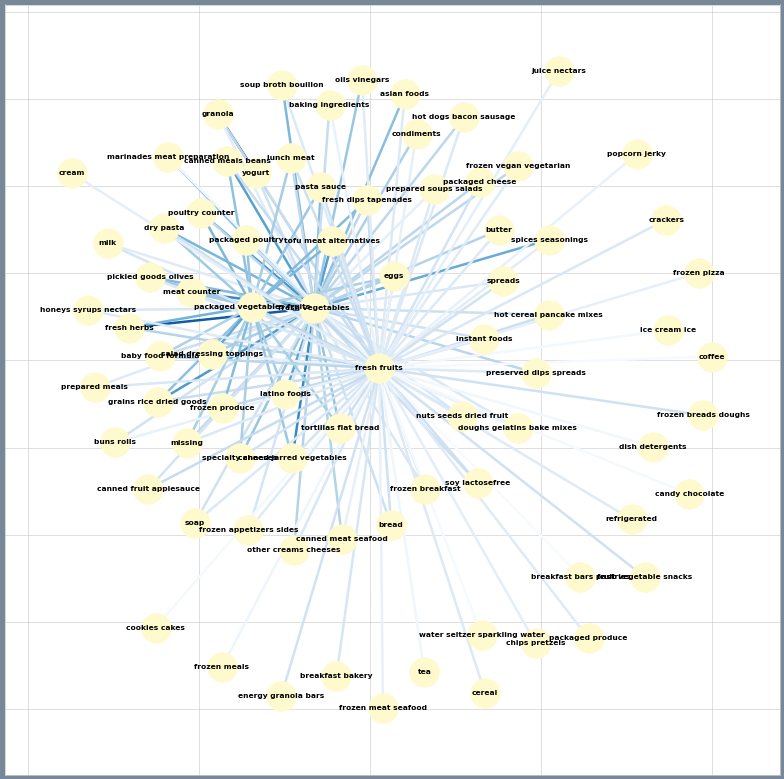

In [25]:

rules = apriori(list(g2["aisle_list"]), support=0.008, confidence=0.5, lift=1.0)

rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC, confidence DESC, support DESC

len(rules_sorted)

rules_list=[]
for r in rules_sorted:
    rules_list.append([list(r[0])[0],list(r[1])[0],r[2],r[3],r[4]])


df_rules=pd.DataFrame(rules_list)
df_rules.columns=["From","To","Support","Confidence","Lift"]

G=nx.from_pandas_edgelist(df_rules,"From","To","Lift")

my_dpi=45
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi,facecolor="lightslategray")

plt.facecolor="Black"
edges = G.edges()
colors = [G[u][v]['Lift'] for u,v in edges]
nx.draw_networkx(G,with_labels=True,node_color="#fffacd",node_size=2250,edge_color=colors, arrows=False,font_color="Black",font_weight="bold",font_size=12,style="solid",width=4,edge_cmap=plt.cm.Blues)



plt.savefig("nx.png",format="png" )
plt.show()